# Задача

Реализовать класс `MyBinaryLogisticRegression` для работы с логистической регрессией. Обеспечить возможность использования `l1`, `l2` и `l1l2` регуляризации и реализовать слудующие методы решения оптимизационной задачи:

*   Градиентный спуск
*   Стохастический градиентный спуск
*   Метод Ньютона

Обосновать применимость/не применимость того или иного метода оптимизации в случае использованного типа регуляризации.



In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from re import L
import scipy
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [ ]:
class MyBinaryLogisticRegression:
    def __init__(self, regularization=None, method = 'gd', lambda_1=0.0, lambda_2=0.0, batch_size=32, learning_rate=0.01, max_iter=1000, random_state=None, epsilon=1e-10):
        self.regularization = regularization
        self.method = method
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.epsilon = epsilon

        self.coefs_ = None
        self.feature_names_in_ = None

    # Сигмоидальная функция
    def _sigmoid(self, z):
      return scipy.special.expit(z)

    # Добавляем столбец из единиц к матрице Х для учета свободного члена в модели
    def _add_intercept(self, X):
        X = np.asarray(X)
        return np.hstack([np.ones((X.shape[0], 1)), X])

    # Градиент
    def _gradient(self, X, y):
        z = X @ self.coefs_
        p = self._sigmoid(z)
        grad = X.T @ (p - y) / X.shape[0]

        if self.regularization in ('l2', 'l1l2'):
            grad[1:] += 2 * self.lambda_2 * self.coefs_[1:]
        if self.regularization in ('l1', 'l1l2'):
            grad[1:] += self.lambda_1 * np.sign(self.coefs_[1:])
        return grad

    # Гессиан
    def _hessian(self, X):
        z = X @ self.coefs_
        p = self._sigmoid(z)
        S = p * (1 - p)

        H = X.T @ (X * S[:, np.newaxis]) / X.shape[0]

        if self.regularization == 'l2':
            reg = 2 * self.lambda_2 * np.eye(X.shape[1])
            reg[0, 0] = 0
            H += reg
        return H

    # Функция потерь
    def _loss(self, X, y):
        z = X @ self.coefs_
        p = self._sigmoid(z)
        p = np.clip(p, self.epsilon, 1 - self.epsilon)
        loss = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
        # регуляризация
        if self.regularization in ('l2', 'l1l2'):
            loss += self.lambda_2 * np.sum(self.coefs_[1:] ** 2)
        if self.regularization in ('l1', 'l1l2'):
            loss += self.lambda_1 * np.sum(np.abs(self.coefs_[1:]))
        return loss

    # Обучаем модель
    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        X = self._add_intercept(X)
        y = y.values.reshape(-1) if isinstance(y, pd.DataFrame) else y.reshape(-1)

        self.coefs_ = np.zeros(X.shape[1])
        if self.random_state is not None:
            np.random.seed(self.random_state)

        prev_loss = np.inf
        n_samples = X.shape[0]

        for _ in range(self.max_iter):
            if self.method == 'gd':
                grad = self._gradient(X, y)
                self.coefs_ -= self.learning_rate * grad
            elif self.method == 'sgd':
                batch_size = min(self.batch_size, n_samples)
                idx = np.random.choice(n_samples, batch_size, replace=False)
                grad = self._gradient(X[idx], y[idx])
                self.coefs_ -= self.learning_rate * grad
            elif self.method == 'newton':
                if self.regularization in ('l1', 'l1l2'):
                    raise ValueError("Метод Ньютона неприменим для L1 и L1L2 регуляризации")
                grad = self._gradient(X, y)
                H = self._hessian(X)
                H += 1e-5 * np.eye(H.shape[0])
                self.coefs_ -= np.linalg.solve(H, grad)

            # проверяем сходимость
            loss = self._loss(X, y)
            if abs(prev_loss - loss) < self.epsilon:
                break
            prev_loss = loss
        return self

    def predict(self, X: pd.DataFrame):
        X = self._add_intercept(X)
        probs = self._sigmoid(X @ self.coefs_)
        return (probs >= 0.5).astype(int)

    def score(self, X: np.array, y: np.array):
        y_pred = self.predict(X)
        return f1_score(y, y_pred)

Продемонстрировать применение реализованного класса на датасете про пингвинов (целевая переменная — вид пингвина). Рассмотреть все возможные варианты (регуляризация/оптимизация). Для категориального признака `island` реализовать самостоятельно преобразование `Target Encoder`, сравнить результаты классификации с `one-hot`. В качестве метрики использовать `f1-score`.

In [ ]:
df = pd.read_csv("penguins_binary_classification.csv")
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,2007
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,2007
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,2007


In [ ]:
# Преобразуем целевую переменную в числовой формат и формируем матрицу признаков
le = LabelEncoder()
y = le.fit_transform(df['species'])
X = df.drop(columns=['species'])

In [ ]:
# Реализуем Target Encoder
def target_encoder_fit(X, y, col):
    data = pd.DataFrame({col: X[col].values, 'target': y})
    mapping = data.groupby(col)['target'].mean().to_dict()
    global_mean = y.mean()
    return mapping, global_mean

def target_encoder_transform(X, col, mapping, global_mean):
    X_enc = X.copy()
    X_enc[col] = X_enc[col].map(mapping).fillna(global_mean).values
    return X_enc

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
# Подготовка данных Target Encoder
mapping, global_mean = target_encoder_fit(X_train, y_train, 'island')
X_train_te = target_encoder_transform(X_train, 'island', mapping, global_mean).astype(float)
X_test_te = target_encoder_transform(X_test, 'island', mapping, global_mean).astype(float)

# Подготовка данных One-Hot Encoder
X_train_oh = pd.get_dummies(X_train, drop_first=True)
X_test_oh = pd.get_dummies(X_test, drop_first=True)
# выравниваем столбцы
X_train_oh, X_test_oh = X_train_oh.align(X_test_oh, join='left', axis=1, fill_value=0)
X_train_oh = X_train_oh.astype(float)
X_test_oh = X_test_oh.astype(float)

In [ ]:
# Параметры
regularizations = [None, 'l1', 'l2', 'l1l2']
methods = ['gd', 'sgd', 'newton']

# Создаем функцию для обучения и оценки модели
def evaluate_model(X_tr, X_te, y_tr, y_te):
    results = []
    for reg in regularizations:
        for method in methods:
            if method == 'newton' and reg in ('l1', 'l1l2'):
                continue
            model = MyBinaryLogisticRegression(regularization=reg, method=method, lambda_1=0.1, lambda_2=0.1, learning_rate=0.05, max_iter=1000, random_state=42)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_te)
            score = f1_score(y_te, y_pred)
            results.append({'regularization': reg, 'method': method, 'f1_score': score})
    return pd.DataFrame(results)

In [ ]:
# Оценка для Target Encoding
print("Target Encoding")
results_te = evaluate_model(X_train_te, X_test_te, y_train, y_test)
print(results_te)

# Оценка для One-Hot Encoding
print("One-Hot Encoding")
results_oh = evaluate_model(X_train_oh, X_test_oh, y_train, y_test)
print(results_oh)

Target Encoding
  regularization  method  f1_score
0           None      gd  0.893617
1           None     sgd  0.648649
2           None  newton  1.000000
3             l1      gd  0.893617
4             l1     sgd  0.648649
5             l2      gd  0.214286
6             l2     sgd  0.675676
7             l2  newton  1.000000
8           l1l2      gd  0.214286
9           l1l2     sgd  0.000000
One-Hot Encoding
  regularization  method  f1_score
0           None      gd  0.893617
1           None     sgd  0.648649
2           None  newton  1.000000
3             l1      gd  0.893617
4             l1     sgd  0.648649
5             l2      gd  0.214286
6             l2     sgd  0.675676
7             l2  newton  1.000000
8           l1l2      gd  0.214286
9           l1l2     sgd  0.000000


**Вывод:** На основе полученных результатов можно отметить, что для категориального признака island качество классификации примерно одинаковое как при использовании Target Encoding, так и при One-Hot Encoding (связано с небольшой мощностью island (3 уникальных значения)).
Наилучшее качество классификации во всех экспериментах демонстрирует метод Ньютона (f1-score = 1.00), что связано с выпуклостью задачи логистической регрессии. Также высокие и стабильные результаты демонстрирует градиентный спуск без регуляризации и с L1-регуляризацией, однако f1-score заметно снижается при использовании L2-регуляризации и L1L2, что может быть связано с большим значением λ, из-за чего коэффициенты сильно "штрафуются". Наихудшие значения показывает стохастический градиентный спуск, что может быть свяано с работой на маленьком датасете, а также достаточно сильной чувствительности к регуляризации.

Таким образом, на данном датасете метод Ньютона является наиболее эффективным способом оптимизации логистической регрессии.

# Теоретическая часть

Пусть данные имеют вид
$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$
причем первая координата набора признаков каждого объекта равна $1$.
Используя `softmax`-подход, дискриминативная модель имеет следующий вид
$$
\mathbb P(C_k|x) = \frac{\exp(\omega_k^Tx)}{\sum_i \exp(\omega_i^Tx)}.
$$
Для написания правдоподобия удобно провести `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat y_i = (y_{11}, \ldots, y_{1M})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид
$$
\mathbb P(D|\omega) = \prod_{i = 1}^{N}\prod_{j = 1}^M \mathbb P(C_j|x_i)^{y_{ij}}.
$$
Ваша задача: вывести функцию потерь, градиент и гессиан для многоклассовой логистической регрессии. Реализовать матрично. На синтетическом примере продемонстрировать работу алгоритма, построить гиперплоскости, объяснить классификацию.

**Функция потерь**

Берем логарифм от правдоподобия (лог-правдоподобие):

$
ln \mathbb P(D|\omega) = \sum_{i = 1}^{N}\sum_{j = 1}^M y_{ij}ln\mathbb P(C_j|x_i).
$

Минимизируем минус лог-правдоподобие:

$L(\omega) = -\sum_{i = 1}^{N}\sum_{j = 1}^M y_{ij}ln\mathbb P(C_j|x_i) $

Находим производную:

$\frac{\partial \mathbb P(C_j|x_i)}{\partial w_{kz}} = x_{iz}P(C_j|x_i)(\delta^{k}_{j} - P(C_k|x_i))$

**Градиент**

$
\frac{\partial L(\omega)}{\partial w_{kz}} = \sum_{i = 1}^{N}x_{iz}(P(C_k|x_i) - y_{ik}) $

Матрично:

$\nabla_W \mathcal{L}(W) = X^\top (P - Y)$

**Гессиан**

Берем вторую производную:

$
\frac{\partial^2 ln \mathbb P(D|\omega)}{\partial w_{pw} \partial w_{kz}} = - \sum_{i = 1}^{N}x_{iz} \frac{\partial \mathbb P(C_k|x_i)}{\partial w_{pw}} = $

подставляем производную softmax

$ = -\sum_{i = 1}^{N}x_{iz} x_{iw} P(C_k|x_i) (\delta^{k}_{p} -P(C_p|x_i)) $

Матрично:

$ H_{kp} = X^\top D_{kp} X $, где

$D_{kp} = diag(P(C_k|x_i)(\delta_{kp} - P(C_p|x_i)))$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

N = 300
X1 = np.random.randn(N//3, 2) + np.array([2, 2])
X2 = np.random.randn(N//3, 2) + np.array([-2, 2])
X3 = np.random.randn(N//3, 2) + np.array([0, -2])

X = np.vstack([X1, X2, X3])
y = np.array([0]*(N//3) + [1]*(N//3) + [2]*(N//3))

# one-hot
M = 3
Y = np.zeros((N, M))
Y[np.arange(N), y] = 1

# добавляем bias
X = np.hstack([np.ones((N,1)), X])

In [ ]:
def softmax(Z):
    Z = Z - Z.max(axis=1, keepdims=True)
    expZ = np.exp(Z)
    return expZ / expZ.sum(axis=1, keepdims=True)

d = X.shape[1]
W = np.zeros((d, M))
lr = 0.1

for _ in range(2000):
    P = softmax(X @ W)
    grad = X.T @ (P - Y)
    W -= lr * grad

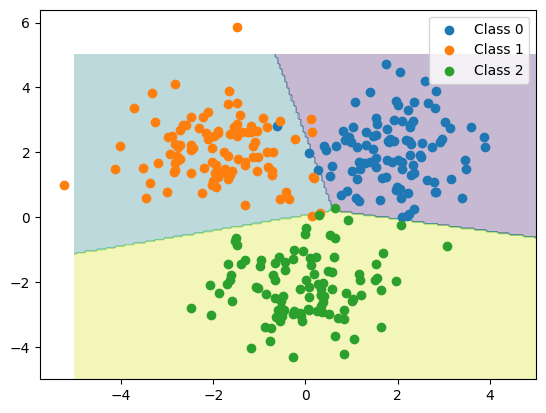

In [ ]:
xx, yy = np.meshgrid(
    np.linspace(-5,5,200),
    np.linspace(-5,5,200))

grid = np.c_[np.ones(xx.size), xx.ravel(), yy.ravel()]
Z = grid @ W
labels = np.argmax(Z, axis=1).reshape(xx.shape)

plt.contourf(xx, yy, labels, alpha=0.3)

plt.scatter(X1[:,0], X1[:,1], label="Class 0")
plt.scatter(X2[:,0], X2[:,1], label="Class 1")
plt.scatter(X3[:,0], X3[:,1], label="Class 2")

plt.legend()
plt.show()

In [ ]:
# новая точка (в двумерном пространстве)
new_point = np.array([2, 0])

new_point_bias = np.hstack([1, new_point])

# вычисляем линейные оценки для всех классов
logits_new = new_point_bias @ W
probabilities_new = softmax(logits_new.reshape(1, -1))

predicted_class = np.argmax(probabilities_new)

print("Вероятности принадлежности к классам:", probabilities_new)
print("Предсказанный класс:", predicted_class)

Вероятности принадлежности к классам: [[7.62655407e-01 4.70690296e-05 2.37297524e-01]]
Предсказанный класс: 0
